# Cytosol Only Cellpose Segmentation with adapted parameters to cellpose model call

In [1]:
import os

import h5py
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

from scportrait.pipeline.featurization import CellFeaturizer
from scportrait.pipeline.extraction import HDF5CellExtraction
from scportrait.pipeline.project import Project
from scportrait.pipeline.segmentation.workflows import CytosolOnlySegmentationCellpose
from scportrait.pipeline.selection import LMDSelection

/Users/sophia/mambaforge/envs/scportrait_new/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
project_location = "project_cytosol_only_custom_segmentation"

project = Project(
    os.path.abspath(project_location),
    config_path="config_example1_custom_params.yml",
    overwrite=True,
    debug=True,
    segmentation_f=CytosolOnlySegmentationCellpose,
    extraction_f=HDF5CellExtraction,
    featurization_f=CellFeaturizer,
    selection_f=LMDSelection,
)

Updating project config file.
[10/02/2025 10:54:16] Loading config from /Users/sophia/Documents/GitHub/scPortrait/examples/notebooks/example_projects/example_1/project_cytosol_only_custom_segmentation/config.yml
INFO     The Zarr backing store has been changed from None the new file path:                                      
         /Users/sophia/Documents/GitHub/scPortrait/examples/notebooks/example_projects/example_1/project_cytosol_on
         ly_custom_segmentation/scportrait.sdata                                                                   
[10/02/2025 10:54:17] Compression algorithm: lzf
[10/02/2025 10:54:17] No cache directory specified in config using current working directory /Users/sophia/Documents/GitHub/scPortrait/examples/notebooks/example_projects/example_1.


In [3]:
from scportrait.data._datasets import dataset_1

dataset_1_path = dataset_1()

# these example images are downloaded from the human protein atlas (www.proteinatlas.org)
images = [f"{dataset_1_path}/Ch1.tif", f"{dataset_1_path}/Ch2.tif", f"{dataset_1_path }/Ch3.tif"]

project.load_input_from_tif_files(images)

[10/02/2025 10:54:17] Output location /Users/sophia/Documents/GitHub/scPortrait/examples/notebooks/example_projects/example_1/project_cytosol_only_custom_segmentation/scportrait.sdata already exists. Overwriting.
INFO     The Zarr backing store has been changed from None the new file path:                                      
         /Users/sophia/Documents/GitHub/scPortrait/examples/notebooks/example_projects/example_1/project_cytosol_on
         ly_custom_segmentation/scportrait.sdata                                                                   
[10/02/2025 10:54:17] Initialized temporary directory at /Users/sophia/Documents/GitHub/scPortrait/examples/notebooks/example_projects/example_1/Project_bl_1c5wm for Project
[10/02/2025 10:54:17] Image input_image written to sdata object.
[10/02/2025 10:54:17] Cleaned up temporary directory at <TemporaryDirectory '/Users/sophia/Documents/GitHub/scPortrait/examples/notebooks/example_projects/example_1/Project_bl_1c5wm'>


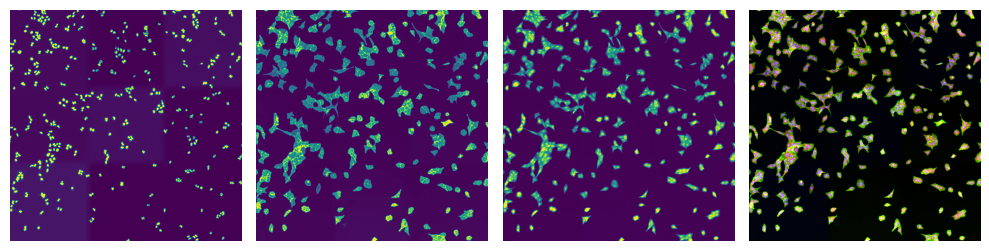

In [4]:
# visualize input images as example
# it is not recommended to execute this block with large input images as it will compute for some time

def colorize(im, color, clip_percentile=0.0):
    """
    Helper function to create an RGB image from a single-channel image using a
    specific color.
    """
    # Check that we do just have a 2D image
    if im.ndim > 2 and im.shape[2] != 1:
        raise ValueError("This function expects a single-channel image!")

    # Rescale the image according to how we want to display it
    im_scaled = im.astype(np.float32) - np.percentile(im, clip_percentile)
    im_scaled = im_scaled / np.percentile(im_scaled, 100 - clip_percentile)
    im_scaled = np.clip(im_scaled, 0, 1)

    # Need to make sure we have a channels dimension for the multiplication to work
    im_scaled = np.atleast_3d(im_scaled)

    # Reshape the color (here, we assume channels last)
    color = np.asarray(color).reshape((1, 1, -1))
    return im_scaled * color


def generate_composite(images, colors=None, plot=False):
    if colors is None:
        colors = [(0, 0, 1), (0, 1, 0), (1, 0, 0), (1, 0, 1)]
    colorized = []
    for image, color in zip(images, colors, strict=False):
        image = colorize(image, color, 0.0)
        colorized.append(image)

    if plot:
        for i in colorized:
            plt.figure()
            plt.imshow(i)

    image = colorized[0]
    for i in range(len(colorized) - 1):
        image += colorized[i + 1]

    return np.clip(image, 0, 1)


fig, axs = plt.subplots(1, 4, figsize=(10, 4))
axs[0].imshow(project.input_image[0])
axs[0].axis("off")

axs[1].imshow(project.input_image[1])
axs[1].axis("off")

axs[2].imshow(project.input_image[2])
axs[2].axis("off")

img = generate_composite(project.input_image)

axs[3].imshow(img)
axs[3].axis("off")

fig.tight_layout()

In [5]:
project.segment()

[10/02/2025 10:54:19] Initialized temporary directory at /var/folders/35/p4c58_4n3bb0bxnzgns1t7kh0000gn/T/./CytosolOnlySegmentationCellpose_xbecr5u8 for CytosolOnlySegmentationCellpose
[10/02/2025 10:54:19] GPU Status for segmentation is True and will segment using the following device mps.
[10/02/2025 10:54:19] Segmentation will be performed wtih all 1 found GPUs.
[10/02/2025 10:54:19] GPU Status for segmentation is True with 1 GPUs found. Segmentation will be performed on the device mps with 1 processes per device in parallel.
[10/02/2025 10:54:19] Segmenting cytosol using the following model: cyto2


/Users/sophia/mambaforge/envs/scportrait_new/lib/python3.10/site-packages/cellpose/dynamics.py:189: RuntimeWarning: invalid value encountered in divide
  mu /= (1e-60 + (mu**2).sum(axis=0)**0.5)


[10/02/2025 10:54:32] Segmentation seg_all_cytosol written to sdata object.
[10/02/2025 10:54:32] Cleaned up temporary directory at <TemporaryDirectory '/var/folders/35/p4c58_4n3bb0bxnzgns1t7kh0000gn/T/./CytosolOnlySegmentationCellpose_xbecr5u8'>


(-0.5, 3036.5, 3038.5, -0.5)

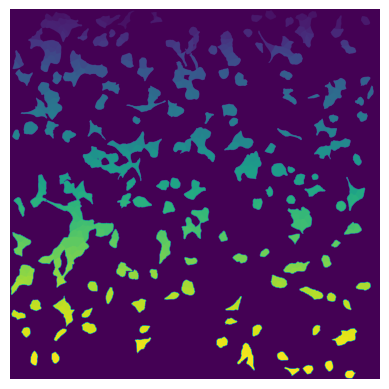

In [6]:
plt.figure()
plt.imshow(project.sdata["seg_all_cytosol"])
plt.axis("off")

[10/02/2025 10:54:33] Initialized temporary directory at /var/folders/35/p4c58_4n3bb0bxnzgns1t7kh0000gn/T/./HDF5CellExtraction_8bmt1npv for HDF5CellExtraction
[10/02/2025 10:54:33] Created new directory for extraction results: /Users/sophia/Documents/GitHub/scPortrait/examples/notebooks/example_projects/example_1/project_cytosol_only_custom_segmentation/extraction/data
[10/02/2025 10:54:33] Setup output folder at /Users/sophia/Documents/GitHub/scPortrait/examples/notebooks/example_projects/example_1/project_cytosol_only_custom_segmentation/extraction/data
[10/02/2025 10:54:33] Found 1 segmentation masks for the given key in the sdata object. Will be extracting single-cell images based on these masks: ['seg_all_cytosol']
[10/02/2025 10:54:33] Using seg_all_cytosol as the main segmentation mask to determine cell centers.
[10/02/2025 10:54:35] Points centers_cells written to sdata object.
[10/02/2025 10:54:35] Extraction Details:
[10/02/2025 10:54:35] --------------------------------
[10/

Extracting cell batches: 100%|██████████| 5/5 [00:00<00:00, 21.08it/s]

[10/02/2025 10:54:35] Finished extraction in 0.30 seconds (1504.29 cells / second)
[10/02/2025 10:54:35] Transferring results to final HDF5 data container.
[10/02/2025 10:54:35] number of cells too close to image edges to extract: 10
[10/02/2025 10:54:35] A total of 10 cells were too close to the image border to be extracted. Their cell_ids were saved to file /Users/sophia/Documents/GitHub/scPortrait/examples/notebooks/example_projects/example_1/project_cytosol_only_custom_segmentation/extraction/removed_classes.csv.


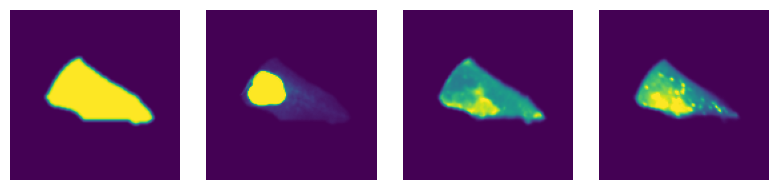

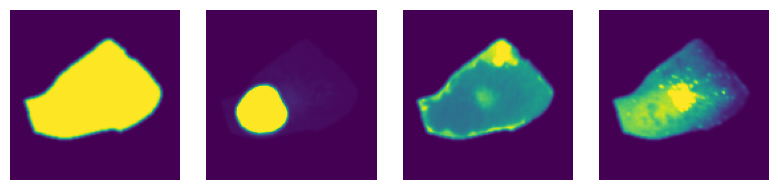

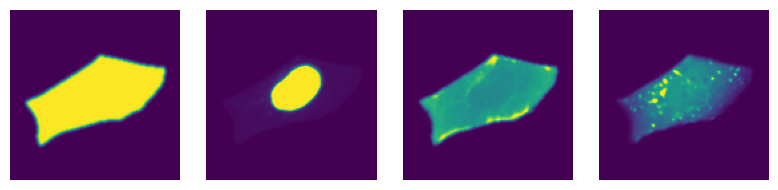

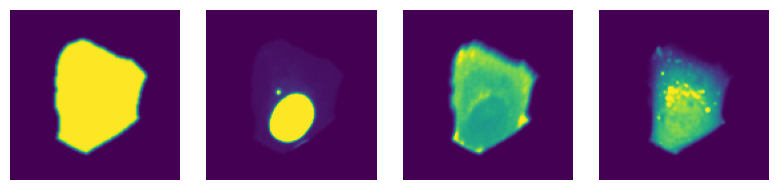

[10/02/2025 10:54:36] Transferring extracted single cells to .hdf5
[10/02/2025 10:54:36] single-cell index created.


Transferring single cell images to HDF5: 100%|██████████| 448/448 [00:00<00:00, 5529.90it/s]

[10/02/2025 10:54:36] single-cell data created
[10/02/2025 10:54:36] single-cell index labelled created.
[10/02/2025 10:54:36] channel information created.


[10/02/2025 10:54:36] Benchmarking times saved to file.
[10/02/2025 10:54:36] Cleaned up temporary directory at <TemporaryDirectory '/var/folders/35/p4c58_4n3bb0bxnzgns1t7kh0000gn/T/./HDF5CellExtraction_8bmt1npv'>


In [7]:
project.extract()

(448, 4, 128, 128)


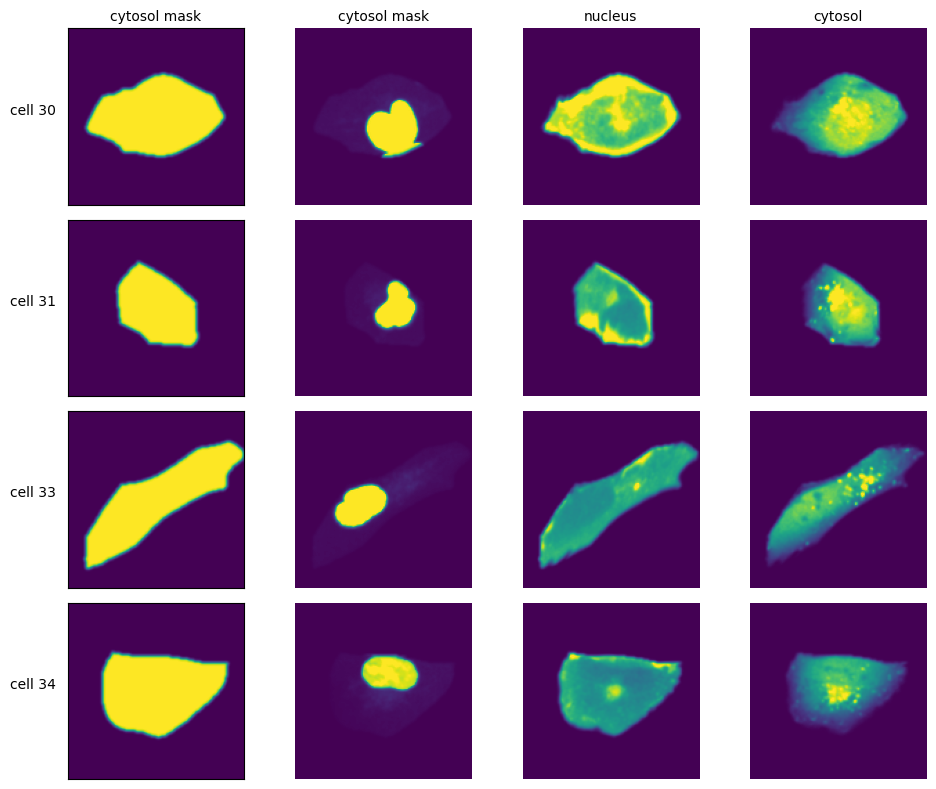

In [8]:
with h5py.File(f"{project_location}/extraction/data/single_cells.h5") as hf:
    index = hf.get("single_cell_index")
    images = hf.get("single_cell_data")

    print(images.shape)

    n_cells = [2, 3, 4, 5]
    fig, axs = plt.subplots(len(n_cells), 4, figsize=(5 * 2, len(n_cells) * 2))
    labels = ["cytosol mask", "cytosol mask", "nucleus", "cytosol", "additional channel"]

    for i, id in enumerate(n_cells):
        cell_id = index[id][1]
        image = images[id]

        for n, _img in enumerate(image):
            axs[i, n].imshow(_img)

            if n == 0:
                axs[i, n].set_ylabel(f"cell {cell_id}", fontsize=10, rotation=0, labelpad=25)
                axs[i, n].xaxis.set_visible(False)
                axs[i, n].tick_params(left=False, labelleft=False)
            else:
                axs[i, n].axis("off")

            if i == 0:
                axs[i, n].set_title(labels[n], fontsize=10)
    fig.tight_layout()

In [9]:
project.featurize()

Using extraction directory: /Users/sophia/Documents/GitHub/scPortrait/examples/notebooks/example_projects/example_1/project_cytosol_only_custom_segmentation/extraction/data/single_cells.h5
[10/02/2025 10:54:36] Initialized temporary directory at /Users/sophia/Documents/GitHub/scPortrait/examples/notebooks/example_projects/example_1/CellFeaturizer_n8abuc0h for CellFeaturizer
[10/02/2025 10:54:36] Started CellFeaturization of all available channels.
[10/02/2025 10:54:36] Created new directory for featurization results: /Users/sophia/Documents/GitHub/scPortrait/examples/notebooks/example_projects/example_1/project_cytosol_only_custom_segmentation/featurization/complete_CellFeaturizer
[10/02/2025 10:54:36] CPU specified in config file but MPS available on system. Consider changing the device for the next run.
[10/02/2025 10:54:36] Reading data from path: /Users/sophia/Documents/GitHub/scPortrait/examples/notebooks/example_projects/example_1/project_cytosol_only_custom_segmentation/extracti

In [12]:
# load classification results
results = pd.read_csv(f"{project_location}/featurization/complete_CellFeaturizer/calculated_image_features.csv")
results

,cytosol_area,1_mean_cytosol,1_median_cytosol,1_quant75_cytosol,1_quant25_cytosol,1_summed_intensity_cytosol,1_summed_intensity_area_normalized_cytosol,2_mean_cytosol,2_median_cytosol,2_quant75_cytosol,...,2_summed_intensity_cytosol,2_summed_intensity_area_normalized_cytosol,3_mean_cytosol,3_median_cytosol,3_quant75_cytosol,3_quant25_cytosol,3_summed_intensity_cytosol,3_summed_intensity_area_normalized_cytosol,label,cell_id
0,7079.0,0.074287,0.0,2.656555e-02,0.0,1217.12320,0.171934,0.220449,0.0,0.617310,...,3611.8333,0.510218,0.110712,0.0,1.233215e-01,0.0,1813.9102,0.256238,0,25
1,3994.0,0.055707,0.0,0.000000e+00,0.0,912.70465,0.228519,0.109351,0.0,0.000000,...,1791.6135,0.448576,0.096727,0.0,0.000000e+00,0.0,1584.7784,0.396790,0,28
2,5276.0,0.076733,0.0,2.228165e-02,0.0,1257.19570,0.238286,0.204703,0.0,0.144440,...,3353.8599,0.635682,0.153220,0.0,3.306580e-02,0.0,2510.3608,0.475808,0,30
3,3473.0,0.046066,0.0,0.000000e+00,0.0,754.73960,0.217316,0.104648,0.0,0.000000,...,1714.5605,0.493683,0.091732,0.0,0.000000e+00,0.0,1502.9292,0.432747,0,31
4,5548.0,0.058010,0.0,1.057434e-02,0.0,950.43726,0.171312,0.136449,0.0,0.094971,...,2235.5815,0.402953,0.108484,0.0,1.224518e-02,0.0,1777.3977,0.320367,0,33
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
443,4322.0,0.034692,0.0,1.192093e-07,0.0,568.39606,0.131512,0.142765,0.0,0.000002,...,2339.0613,0.541199,0.090601,0.0,4.768372e-07,0.0,1484.4119,0.343455,0,504
444,3367.0,0.059293,0.0,0.000000e+00,0.0,971.45447,0.288522,0.103432,0.0,0.000000,...,1694.6229,0.503304,0.082101,0.0,0.000000e+00,0.0,1345.1432,0.399508,0,505
445,5732.0,0.037275,0.0,1.891613e-03,0.0,610.71720,0.106545,0.204987,0.0,0.249817,...,3358.5150,0.585924,0.124530,0.0,1.269913e-02,0.0,2040.2991,0.355949,0,506
446,5702.0,0.052232,0.0,2.714634e-03,0.0,855.76470,0.150082,0.179016,0.0,0.348267,...,2932.9958,0.514380,0.131524,0.0,4.881287e-02,0.0,2154.8926,0.377919,0,507


In [13]:
#test selection workflow
selected_cells_large = results[results.cytosol_area > 4500]["cell_id"].tolist()
selected_cells_small = results[results.cytosol_area < 3000]["cell_id"].tolist()

cells_to_select = [
    {"name": "large_cells", "classes": selected_cells_large, "well": "A1"},
    {"name": "small_cells", "classes": selected_cells_small, "well": "B1"},
]

marker_0 = (0, 0)
marker_1 = (2000, 0)
marker_2 = (0, 2000)

calibration_marker = np.array([marker_0, marker_1, marker_2])

[10/02/2025 10:55:22] Initialized temporary directory at /var/folders/35/p4c58_4n3bb0bxnzgns1t7kh0000gn/T/./LMDSelection_rt05igl4 for LMDSelection
[10/02/2025 10:55:22] Selection process started.


Processing cell batches: 100%|██████████| 3/3 [00:05<00:00,  1.84s/it]


[10/02/2025 10:55:28] Temporary directory not found, skipping cleanup
[10/02/2025 10:55:28] Temporary directory not found, skipping cleanup
[10/02/2025 10:55:28] Temporary directory not found, skipping cleanup
[10/02/2025 10:55:28] Coordinate lookup index calculation took 6.831400875002146 seconds.
No configuration for shape_erosion found, parameter will be set to 0
No configuration for binary_smoothing found, parameter will be set to 3
No configuration for convolution_smoothing found, parameter will be set to 15
No configuration for rdp_epsilon found, parameter will be set to 0.1
No configuration for xml_decimal_transform found, parameter will be set to 100
No configuration for distance_heuristic found, parameter will be set to 300
No configuration for join_intersecting found, parameter will be set to True
Path optimizer used for XML generation: hilbert
cell set 0 passed sanity check
cell set 1 passed sanity check
Loading coordinates from external source
Processing cell sets in parall

dilating shapes: 100%|██████████| 217/217 [00:03<00:00, 54.69it/s]


0 shapes that were intersecting were found and merged.


calculating polygons:   0%|          | 0/35 [00:00<?, ?it/s]

0 shapes that were intersecting were found and merged.


calculating polygons: 100%|██████████| 35/35 [00:03<00:00, 11.13it/s]


Current path length: 37,895.11 units
Optimized path length: 15,986.20 units
Optimization factor: 2.4x
Plotting shapes in debug mode is not supported in multi-threading mode.
Saving plots to disk instead.
collecting cell sets:  50%|█████     | 1/2 [00:11<00:11, 11.53s/it]

calculating polygons: 100%|██████████| 83/83 [00:09<00:00,  8.73it/s]


Current path length: 83,648.03 units
Optimized path length: 26,933.88 units
Optimization factor: 3.1x
Plotting shapes in debug mode is not supported in multi-threading mode.
Saving plots to disk instead.
collecting cell sets: 100%|██████████| 2/2 [00:22<00:00, 11.00s/it]


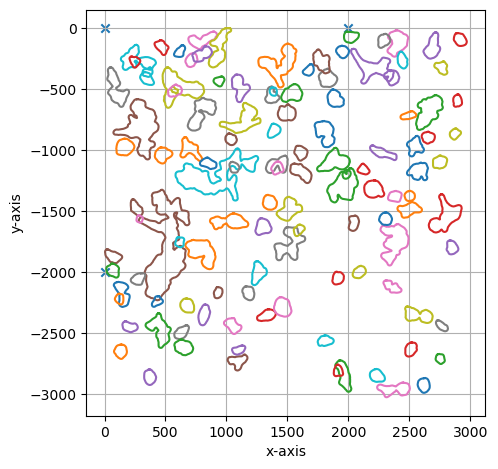

===== Collection Stats =====
Number of shapes: 118
Number of vertices: 17,076
Mean vertices: 145
Min vertices: 59
5% percentile vertices: 73
Median vertices: 102
95% percentile vertices: 322
Max vertices: 856
[0 0]
[      0 -200000]
[200000      0]
[10/02/2025 10:55:51] Saved output at /Users/sophia/Documents/GitHub/scPortrait/examples/notebooks/example_projects/example_1/project_cytosol_only_custom_segmentation/selection/large_cells_small_cells.xml
[10/02/2025 10:55:51] Cleaned up temporary directory at <TemporaryDirectory '/var/folders/35/p4c58_4n3bb0bxnzgns1t7kh0000gn/T/./LMDSelection_rt05igl4'>


In [14]:
project.selection_f.segmentation_channel_to_select = "seg_all_cytosol" #update to the correct channel for this notebook with out loading a different config
project.select(cells_to_select, calibration_marker)